## 1. Imports and Dataset **Preparation**

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU
from tensorflow.keras.layers import BatchNormalization
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the data to be between -1 and 1 (better for GAN training)
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)  # Add a channel dimension

# Create batches of training data
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 2. Creating the Generator Model

In [2]:
# Define the Generator model
def create_generator():
    model = tf.keras.Sequential()
    model.add(Dense(256, input_shape=(100,)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model

## 3. Creating the Discriminator Model

In [3]:
# Define the Discriminator model
def create_discriminator():
    model = tf.keras.Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

## 4. Compiling the Models

In [4]:
# Create the generator and discriminator models
generator = create_generator()
discriminator = create_discriminator()

# Compile the discriminator
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create the GAN by combining generator and discriminator
discriminator.trainable = False  # Freeze the discriminator during GAN training
gan_input = tf.keras.Input(shape=(100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = tf.keras.Model(gan_input, gan_output)

# Compile the GAN model
gan.compile(optimizer='adam', loss='binary_crossentropy')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 5. Training Function for GAN

In [8]:
# Updated training function for the GAN
def train_gan(generator, discriminator, gan, dataset, epochs=10000):
    for epoch in range(epochs):
        for real_images in dataset:
            # Ensure the batch size is consistent for both real and fake images
            current_batch_size = real_images.shape[0]

            # Generate fake images with the same batch size as the real images
            noise = np.random.normal(0, 1, (current_batch_size, 100))
            fake_images = generator.predict(noise)

            # Combine real and fake images
            combined_images = np.concatenate([real_images, fake_images])

            # Create labels for real (1) and fake (0) images
            labels = np.concatenate([np.ones((current_batch_size, 1)), np.zeros((current_batch_size, 1))])

            # Add some noise to the labels to improve training stability (label smoothing)
            labels += 0.05 * np.random.random(labels.shape)

            # Train the discriminator on real and fake data
            d_loss, d_acc = discriminator.train_on_batch(combined_images, labels)

            # Generate noise for the generator training step
            noise = np.random.normal(0, 1, (current_batch_size, 100))
            misleading_labels = np.ones((current_batch_size, 1))  # We want the generator to fool the discriminator

            # Train the generator via the GAN model (with frozen discriminator)
            g_loss = gan.train_on_batch(noise, misleading_labels)

        # Display progress and generate sample images at specific intervals
        if epoch % 1000 == 0:
            print(f"Epoch: {epoch}, Discriminator Loss: {d_loss}, Accuracy: {d_acc}, Generator Loss: {g_loss}")
            generate_and_save_images(generator, epoch)

## 6. Generating and Saving Images

In [9]:
# Function to generate and save images during training
def generate_and_save_images(generator, epoch):
    noise = np.random.normal(0, 1, (16, 100))
    generated_images = generator.predict(noise)

    plt.figure(figsize=(4, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}")
    plt.show()

## 7. Training the GAN


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━

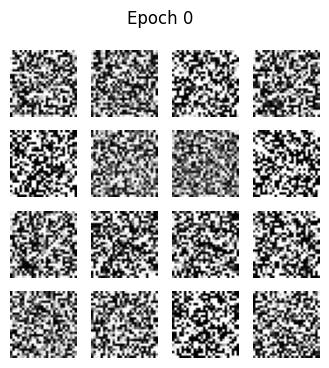

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [ ]:
# Train the GAN with a smaller number of epochs for faster training
train_gan(generator, discriminator, gan, train_dataset, epochs=50)
